# DFTK tour and eigensolvers

*(adapted from the [DFTK documentation](https://docs.dftk.org/dev/guide/discretisation/))*

## Some words about DFTK

<img src="img/dftk_overview.png" />

- Code: https://dftk.org
- Documentation: https://docs.dftk.org
- Pretty much all examples also part of the docs

## A first problem to look at

We start simple and consider the *linear* Hamiltonian
$$
   H = - \frac12 Δ + V(x) \quad \text{with $V(x) = \cos(x)$}
$$
on $[0, 2π]$ with periodic boundary conditions.
In this problem the $\cos(x)$ takes the role of
a lattice-periodic potential and we are asked to solve a simple eigenproblem
$$
    H \psi_n = ε_n \psi_n \qquad \langle \psi_n, \psi_m\rangle = δ_{mn}
$$
for the smallest eigenvalue.

The DFTK code uses plane waves as discussed in Antoine's lecture.
We tuhs expand states $\psi_n$ on the basis
$$
   e_G(x) = \frac{1}{\sqrt{2\pi}} e^{iGx} \qquad \text{for $G=-N,\dots,N$}.
$$

To deal with a 1D case we use a 3D lattice with two lattice vectors set to zero.

In [1]:
using DFTK
a = 2π
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

Define Hamiltonian: Kinetic + Potential

In [2]:
terms = [Kinetic(),
         ExternalFromReal(r -> cos(r[1]))]  # r is a vector of size 3
model = Model(lattice; n_electrons=1, terms, spin_polarization=:spinless);  # One spinless electron

Ecut defines the number of plane waves by selecting all those $G$, which satisfy
the relationship $½ |G|^2 ≤ \text{Ecut}$.

In [3]:
Ecut = 500
basis = PlaneWaveBasis(model; Ecut, kgrid=(1, 1, 1))

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 500.0 Ha
    fft_size             : (135, 1, 1), 135 total points
    kgrid                : MonkhorstPack([1, 1, 1])
    num.   red. kpoints  : 1
    num. irred. kpoints  : 1

    Discretized Model(custom, 1D):
        lattice (in Bohr)    : [6.28319   , 0         , 0         ]
                               [0         , 0         , 0         ]
                               [0         , 0         , 0         ]
        unit cell volume     : 6.2832 Bohr
    
        num. electrons       : 1
        spin polarization    : spinless
        temperature          : 0 Ha
    
        terms                : Kinetic()
                               ExternalFromReal(var"#8#9"())

We now seek the ground state. To better separate the two steps (SCF outer loop
and diagonalization inner loop), we set the diagtol (the tolerance of the eigensolver)
to a small value.

In [4]:
scfres = self_consistent_field(basis; tol=1e-4)
scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -0.535064852288                   -0.22   10.0    2.20s
  2   -0.535064852288      -13.57       -0.91    1.0    1.85s
  3   -0.535064852288      -15.35       -8.52    1.0   28.1ms


Energy breakdown (in Ha):
    Kinetic             0.2090845 
    ExternalFromReal    -0.7441493

    total               -0.535064852288

On this simple linear (non-interacting) model, the SCF converges in one step.
The ground state energy of is simply the lowest eigenvalue, which we can easily check:

In [5]:
scfres.eigenvalues[1]

4-element Vector{Float64}:
 -0.5350648522878154
  0.3433601283990823
  0.8536343543208004
  2.0569044598265043

## Plotting
We can also get the first eigenvector (in the plane wave basis) and plot it

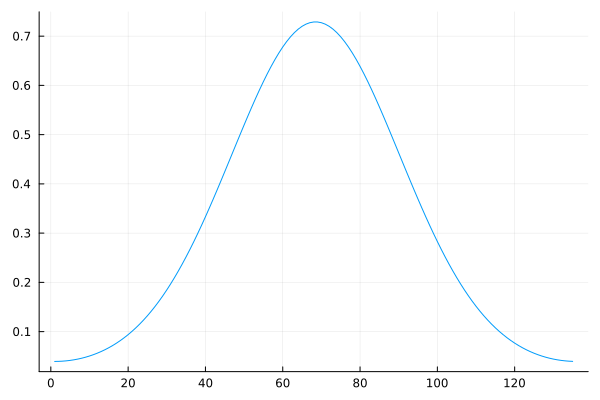

In [6]:
using Plots

ψ_fourier = scfres.ψ[1][:, 1];    # first k-point, all G components, first eigenvector
# Transform the wave function to real space
ψ = ifft(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
# Eigenvectors are only defined up to a phase. We fix it by imposing that psi(0) is real
ψ /= (ψ[1] / abs(ψ[1]))
plot(real(ψ); label="")

and we can look at the Fourier coefficients similarly easily:

## The DFTK Hamiltonian
We can ask DFTK for the Hamiltonian

In [7]:
E, ham = energy_hamiltonian(basis, scfres.ψ, scfres.occupation;
                            ρ=scfres.ρ)
H = ham[1]
typeof(H)

DFTK.DftHamiltonianBlock

This is an opaque data structure, which encodes the Hamiltonian. What can we do with it?

In [8]:
using InteractiveUtils
methodswith(typeof(H), supertypes=true)

[1] Array(block::HamiltonianBlock) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:74
[2] *(H::HamiltonianBlock, ψ) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:62
[3] (Matrix)(block::HamiltonianBlock) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:75
[4] eltype(block::HamiltonianBlock) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:63
[5] size(block::HamiltonianBlock, i::Integer) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:64
[6] size(block::HamiltonianBlock) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/terms/Hamiltonian.jl:65
[7] mul!(Hψ::AbstractArray, H::DFTK.DftHamiltonianBlock, ψ::AbstractArray) @ DFTK ~/.julia/packages/TimerOutputs/RsWnF/src/TimerOutput.jl:230
[8] PreconditionerNone(::HamiltonianBlock) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/eigen/preconditioners.jl:21
[9] PreconditionerTPA(ham::HamiltonianBlock; kwargs...) @ DFTK ~/.julia/packages/DFTK/cvuxi/src/eigen/preconditioners.jl:45

This defines a number of methods. For instance, it can be used as a linear operator:

In [9]:
H * DFTK.random_orbitals(basis, basis.kpoints[1], 1)

63×1 Matrix{ComplexF64}:
  -0.07199197349550847 + 0.02985572801672903im
  0.010745160145909795 + 0.00271027750578204im
     0.156202543258937 + 0.1178308049104572im
  -0.29217759848238256 + 0.0407671411451903im
   0.26822789164544203 - 0.7305679188280638im
  -0.11816978270040723 + 2.6829821335816195im
 -0.017288774628414535 - 0.6640987772017206im
    -3.097851348195021 + 4.225759447501951im
   -2.1149822241349416 + 3.01887492896433im
    11.175172966733193 - 2.4632867300913395im
     2.817333898313969 + 2.2509244792122516im
     9.388754014328944 + 7.63036855401389im
      4.68283895097643 - 0.6085998760129536im
                       ⋮
   -2.4597430687783355 + 9.613946688521649im
     -9.13971808202327 - 2.1398078586677847im
    -9.045552734455097 + 2.6332861060882133im
    0.5852127832676497 - 1.8493465723580438im
   -3.4193212244977857 + 0.21929832521912843im
     3.762721894479373 - 2.2153394699206115im
   -0.5740362784393942 + 2.1039233853126724im
   -0.5005188226385069 + 0.319281

We can also get its full matrix representation:

In [10]:
Array(H)

63×63 Matrix{ComplexF64}:
 -3.54526e-17+0.0im          …           0.5-5.31073e-17im
          0.5-5.31073e-17im      1.61891e-17+7.85117e-18im
  1.61891e-17+7.85117e-18im      -1.3268e-18+3.621e-18im
  -1.3268e-18+3.621e-18im       -7.46547e-19-1.64087e-17im
 -7.46547e-19-1.64087e-17im      1.17262e-17-8.51348e-18im
  1.17262e-17-8.51348e-18im  …   8.28558e-18+4.58885e-18im
  8.28558e-18+4.58885e-18im     -1.01867e-17+1.95109e-17im
 -1.01867e-17+1.95109e-17im      5.05619e-18+8.61013e-18im
  5.05619e-18+8.61013e-18im      2.06743e-18+3.50495e-18im
  2.06743e-18+3.50495e-18im     -2.56573e-18+1.79786e-18im
 -2.56573e-18+1.79786e-18im  …  -9.98231e-18+6.03587e-18im
 -9.98231e-18+6.03587e-18im     -2.83101e-17-3.72189e-19im
 -2.83101e-17-3.72189e-19im      -4.8562e-18-3.6278e-17im
             ⋮               ⋱  
 -2.83101e-17+3.72189e-19im     -9.98231e-18-6.03587e-18im
 -9.98231e-18-6.03587e-18im     -2.56573e-18-1.79786e-18im
 -2.56573e-18-1.79786e-18im      2.06743e-18-3.50495e-18im


or supressing the small entries and the imaginary parts (which are zero by symmetry):

In [11]:
H_filtered = real(Array(H))
H_filtered[abs.(H_filtered) .< 1e-6] .= 0
H_filtered

63×63 Matrix{Float64}:
 0.0  0.5  0.0  0.0  0.0   0.0   0.0   0.0  …   0.0   0.0  0.0  0.0  0.0  0.5
 0.5  0.5  0.5  0.0  0.0   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.5  2.0  0.5  0.0   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  4.5  0.5   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.5  8.0   0.5   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  12.5   0.5   0.0  …   0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.5  18.0   0.5      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.5  24.5      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.5      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  …   0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.

## Coding up our own eigensolver

A simple (and not fully numerically stable) implementation of LOBPCG is given below.

It is a simplified version of the [implementation we employ in DFTK](https://github.com/JuliaMolSim/DFTK.jl/blob/3cd0bd40658ead7146de8945a7156f2b15ffc711/src/eigen/lobpcg_hyper_impl.jl).

In [12]:
function qrortho(X::ArrayType) where {ArrayType <: AbstractArray}
    convert(ArrayType, qr(X).Q)
end
qrortho(X, Y) = qrortho(X - Y * Y'X)

function rayleigh_ritz(X::Array, AX::Array, N)
    F = eigen(Hermitian(X'AX))
    F.vectors[:,1:N], F.values[1:N]
end

function lobpcg(A, X; prec=I, tol=1e-7, maxiter=100, display_progress=false, kwargs...)
    N, M = size(X)
    X  = qrortho(X)
    AX = A * X
    λs = diag(X'AX)  # X are orthonormal

    P  = nothing
    AP = nothing
    R  = nothing
    AR = nothing

    n_iter = 0
    converged = false
    while n_iter < maxiter
        # Matvec and Rayleigh-Ritz
        if n_iter > 0
            AR = A * R

            if n_iter > 1
                Y  = [X R P]
                AY = [AX AR AP]
            else
                Y  = [X R]
                AY = [AX AR]
            end
            cX, λs = rayleigh_ritz(Y, AY, M)

            X  = Y  * cX
            AX = AY * cX
        end

        # New residuals
        R = AX .- X .* λs'
        rnorms = map(norm, eachcol(R))
        display_progress && println("Iter $n_iter, resid ", rnorms)
        converged = maximum(rnorms) < tol
        converged && break

        # New search direction
        if n_iter > 0
            cP = copy(cX)
            cP[1:M, 1:M] .= cX[1:M, 1:M] - I
            cP = qrortho(cP, cX)
            P  = Y  * cP
            AP = AY * cP
        end

        # Preconditioning and residual orthonormality
        if n_iter > 0
            Z = [X P]
        else
            Z = X
        end
        R = qrortho(prec \ R, Z)
        
        n_iter += 1
    end

    λ = real(diag(X' * AX))
    residuals = AX .- X * Diagonal(λ)
    (; X, λ, residuals, residual_norms=norm.(residuals),
       converged, n_iter, n_matvec=0)
end

lobpcg (generic function with 1 method)

Applying it to our (rather simple) test problem above, we see that it works, but is horribly slow:

In [13]:
ψ0  = randn(ComplexF64, (size(H, 2), 1))
res = lobpcg(H, ψ0; tol=1e-6, display_progress=true);

Iter 0, resid [146.81602809616942]
Iter 1, resid [77.17609157354086]
Iter 2, resid [44.292790663752164]
Iter 3, resid [25.551806140680824]
Iter 4, resid [20.143760265908504]
Iter 5, resid [14.6858082102675]
Iter 6, resid [11.473652725549782]
Iter 7, resid [9.817454999009218]
Iter 8, resid [8.731627771226488]
Iter 9, resid [7.023490706236077]
Iter 10, resid [6.401407915673473]
Iter 11, resid [5.678276433008404]
Iter 12, resid [5.160178109602341]
Iter 13, resid [4.314777210617065]
Iter 14, resid [3.891712920106008]
Iter 15, resid [3.392322003434821]
Iter 16, resid [3.4392205643005447]
Iter 17, resid [3.664192587008284]
Iter 18, resid [3.633314819287929]
Iter 19, resid [3.410043581963781]
Iter 20, resid [4.034240314294644]
Iter 21, resid [4.732286650096888]
Iter 22, resid [4.454230151178407]
Iter 23, resid [3.7202930201281257]
Iter 24, resid [4.356465633948536]
Iter 25, resid [3.7086290255655587]
Iter 26, resid [3.4424932923481384]
Iter 27, resid [3.3977670293753395]
Iter 28, resid [2.669

To remedy this we employ preconditioning. As Antoine discussed in the Fourier basis, the kinetic energy operator $-\frac12\Delta$ is diagonal:
$$
\frac{1}{\Omega} \langle e^{-iGx}, -\frac12\Delta\, e^{-i \widetilde{G} x} \rangle
= \frac12 |G|^2\, δ_{G\widetilde{G}}
$$

Therefore it is diagonal and a natural preconditioner to employ. Since the kinetic energy of individual orbitals is a bit higher than the lowest (zero) kinetic energy, usually a more balanced preconditioning strategy is
$$
P^{-1}\, e^{-i \widetilde{G} x} = \frac{1}{α + \frac12 |G|^2} e^{-i \widetilde{G} x}
$$
where $α > 0$ and chosen adaptively for each orbital. Here we just take a fixed $α=0.5$:

In [14]:
function preconditioner(H)
    Gs = Gplusk_vectors_cart(H.basis, H.kpoint)
    coefficients = [0.5 + norm(G)^2 / 2 for G in Gs]
    Diagonal(coefficients)
end

preconditioner (generic function with 1 method)

In [15]:
ψ0  = randn(ComplexF64, (size(H, 2), 1))
res = lobpcg(H, ψ0; tol=1e-6, display_progress=true, prec=preconditioner(H));

Iter 0, resid [143.03522478247658]
Iter 1, resid [2.529904058394579]
Iter 2, resid [1.2716466460188784]
Iter 3, resid [0.2694321415981735]
Iter 4, resid [0.08911660123376242]
Iter 5, resid [0.020838101024314007]
Iter 6, resid [0.008247094668859025]
Iter 7, resid [0.0013481339231000565]
Iter 8, resid [0.0004331792298512439]
Iter 9, resid [9.441810632427708e-5]
Iter 10, resid [2.028378830264157e-5]
Iter 11, resid [3.9731487402986e-6]
Iter 12, resid [1.1960340306424805e-6]
Iter 13, resid [2.0882816224459347e-7]


## Integrating a custom eigensolver into DFTK

More details: https://docs.dftk.org/dev/examples/custom_solvers/


We integrate our solver to DFTK, where we can directly apply it to a real problem:

In [26]:
using ASEconvert
using LazyArtifacts

ase_Si = ase.build.bulk("Si"; cubic=true)
system = attach_psp(pyconvert(AbstractSystem, ase_Si); Si="hgh/pbe/Si-q4")

FlexibleSystem(Si₈, periodic = TTT):
    bounding_box      : [    5.43        0        0;
                                0     5.43        0;
                                0        0     5.43]u"Å"

    Atom(Si, [       0,        0,        0]u"Å")
    Atom(Si, [  1.3575,   1.3575,   1.3575]u"Å")
    Atom(Si, [       0,    2.715,    2.715]u"Å")
    Atom(Si, [  1.3575,   4.0725,   4.0725]u"Å")
    Atom(Si, [   2.715,        0,    2.715]u"Å")
    Atom(Si, [  4.0725,   1.3575,   4.0725]u"Å")
    Atom(Si, [   2.715,    2.715,        0]u"Å")
    Atom(Si, [  4.0725,   4.0725,   1.3575]u"Å")

       .------------.  
      /|            |  
     / |  Si        |  
    *  |            |  
    |  |      Si    |  
    | Si            |  
    |  |  Si    Si  |  
    |  .------------.  
    | / Si  Si     /   
    |/            /    
    Si-----------*     


On this system we consider a real DFT problem:

In [29]:
model = model_PBE(system)
basis = PlaneWaveBasis(model; Ecut=15, kgrid=[1, 1, 1])
ρ = guess_density(basis);

E.g. we can diagonalise an arising Hamiltonian with our solver:

In [28]:
E, ham = energy_hamiltonian(basis, nothing, nothing; ρ)
H = ham[1];
ψ = DFTK.random_orbitals(H.basis, H.kpoint, 2)

res = lobpcg(H, ψ; tol=1e-4, display_progress=true, prec=preconditioner(H));

Iter 0, resid [3.9123766357054626, 3.994452389735462]
Iter 1, resid [1.6212797419116902, 1.6933489919762903]
Iter 2, resid [0.5877389555324771, 0.5832398328934292]
Iter 3, resid [0.31486073100492007, 0.27754535383859075]
Iter 4, resid [0.16253152659008727, 0.14153281883795465]
Iter 5, resid [0.07928960422862959, 0.06248527105228496]
Iter 6, resid [0.04247951206155342, 0.02886902216013414]
Iter 7, resid [0.021173060103309143, 0.015599769417991943]
Iter 8, resid [0.008337397139021631, 0.0067977898238137475]
Iter 9, resid [0.002499497992611563, 0.0021598653525664183]
Iter 10, resid [0.0007217227637900494, 0.00082628637168905]
Iter 11, resid [0.00019736932215687914, 0.00033736374899003734]
Iter 12, resid [9.268806870314226e-5, 0.00013021660091539638]
Iter 13, resid [5.360758854363753e-5, 4.516163704181088e-5]


or directly integrate it into the full SCF loop:

In [32]:
scfres = self_consistent_field(basis; ρ, tol=1e-4, eigensolver=lobpcg);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -31.11301542659                   -0.34   12.0    320ms
  2   -31.12995780831       -1.77       -1.14    1.0   86.3ms
  3   -31.13125412846       -2.89       -2.04    2.0    108ms
  4   -31.13106074346   +   -3.71       -2.10   14.0    380ms
  5   -31.13136082570       -3.52       -2.70    2.0    111ms
  6   -31.13137900566       -4.74       -2.90    5.0    178ms
  7   -31.13138255164       -5.45       -3.23    2.0    193ms
  8   -31.13138320212       -6.19       -3.48    2.0    403ms
  9   -31.13138364267       -6.36       -3.99    4.0    410ms
 10   -31.13138366420       -7.67       -4.28    3.0    137ms


Note that this works immediately on the GPU as well:

In [33]:
using CUDA
if CUDA.has_cuda()
    basis  = PlaneWaveBasis(model; Ecut=15, kgrid=[1, 1, 1], architecture=DFTK.GPU(CuArray))
    scfres = self_consistent_field(basis; ol=1e-4, eigensolver=lobpcg,
                                   scf_damping_solver(1.0));
end